In [583]:
import numpy as np
import pandas as pd
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [584]:
bitcoin_path = './data/Bitcoin_5_14_2010-5_19_2025_historical_data_coinmarketcap.xlsx'
fedfunds_path = './data/FEDFUNDS.xlsx'
us_dollar_index_path = './data/US_Dollar_Index_Historical_Data.csv'
events_impact = './data/Bitcoin_Event_Impact.csv'

df_btc = pd.read_excel(bitcoin_path)
df_fed = pd.read_excel(fedfunds_path)
df_usd = pd.read_csv(us_dollar_index_path)
df_events = pd.read_csv(events_impact)

print(df_btc.head())
print('________')
print(df_fed.head())
print('________')
print(df_usd.head())
print('________')
print(df_events.head())

                   timeOpen                 timeClose  \
0  2025-05-19T00:00:00.000Z  2025-05-19T23:59:59.999Z   
1  2025-05-18T00:00:00.000Z  2025-05-18T23:59:59.999Z   
2  2025-05-17T00:00:00.000Z  2025-05-17T23:59:59.999Z   
3  2025-05-16T00:00:00.000Z  2025-05-16T23:59:59.999Z   
4  2025-05-15T00:00:00.000Z  2025-05-15T23:59:59.999Z   

                   timeHigh                   timeLow  name           open  \
0  2025-05-19T00:09:00.000Z  2025-05-19T06:40:00.000Z  2781  106430.532703   
1  2025-05-18T23:59:00.000Z  2025-05-18T00:02:00.000Z  2781  103186.955636   
2  2025-05-17T05:04:00.000Z  2025-05-17T01:48:00.000Z  2781  103489.289736   
3  2025-05-16T16:06:00.000Z  2025-05-16T08:26:00.000Z  2781  103735.655063   
4  2025-05-15T17:46:00.000Z  2025-05-15T14:47:00.000Z  2781  103538.825684   

            high            low          close        volume     marketCap  \
0  107068.722368  102112.685460  105606.181468  6.176113e+10  2.098071e+12   
1  106597.168134  103142.604579 

In [585]:
# Normalize the time cols for merge
df_btc['timestamp'] = pd.to_datetime(df_btc['timestamp']).dt.date
df_fed['observation_date'] = pd.to_datetime(df_fed['observation_date'])
df_usd['Date'] = pd.to_datetime(df_usd['Date'], format='%m/%d/%Y').dt.date
df_events['date'] = pd.to_datetime(df_events['date']).dt.date

# DF for all day from bitcoin data
start_date = df_btc['timestamp'].min()
end_date = df_btc['timestamp'].max()
all_dates = pd.date_range(start=start_date, end=end_date, freq='D').date
df_all_dates = pd.DataFrame({'timestamp': all_dates})

# DF for Fedfunds
df_fed['month'] = pd.to_datetime(df_fed['observation_date']).dt.to_period('M')
df_all_dates['month'] = pd.to_datetime(df_all_dates['timestamp']).dt.to_period('M')
df_fed_mapped = df_all_dates.merge(df_fed[['month', 'FEDFUNDS']], on='month', how='left')
print(df_fed_mapped.head())

# DF for US_Dollar_Index
df_usd = df_usd[['Date', 'Price']].rename(columns={'Price': 'US_Dollar_Price'})
df_usd = df_all_dates.merge(df_usd, left_on='timestamp', right_on='Date', how='left')
df_usd['US_Dollar_Price'] = df_usd['US_Dollar_Price'].ffill()
print(df_usd.head())

# DF for Events Impact
impact_data = []
for _, row in df_events.iterrows():
  event_date = row['date']
  impact = row['impact']
  days_before = row['days_before']
  days_after = row['days_after']

  start_date = event_date - pd.Timedelta(days=days_before)
  end_date = event_date + pd.Timedelta(days=days_after)
  date_range = pd.date_range(start=start_date, end=end_date, freq='D').date

  for d in date_range:
    impact_data.append({'timestamp': d, 'impact': impact})

df_impact = pd.DataFrame(impact_data)
print(df_impact.head())

    timestamp    month  FEDFUNDS
0  2010-07-14  2010-07      0.18
1  2010-07-15  2010-07      0.18
2  2010-07-16  2010-07      0.18
3  2010-07-17  2010-07      0.18
4  2010-07-18  2010-07      0.18
    timestamp    month        Date  US_Dollar_Price
0  2010-07-14  2010-07  2010-07-14            83.43
1  2010-07-15  2010-07  2010-07-15            82.56
2  2010-07-16  2010-07  2010-07-16            82.49
3  2010-07-17  2010-07         NaN            82.49
4  2010-07-18  2010-07         NaN            82.49
    timestamp  impact
0  2010-07-13       1
1  2010-07-14       1
2  2010-07-15       1
3  2010-07-16       1
4  2010-07-17       1


In [586]:
# Merge all df into 1 df
df_merged = df_btc.merge(df_fed_mapped[['timestamp', 'FEDFUNDS']], how='left', on='timestamp')
df_merged = df_merged.merge(df_usd[['timestamp', 'US_Dollar_Price']], how='left', on='timestamp')
df_merged = df_merged.merge(df_impact, how='left', on='timestamp')

# Fill 0 for all days with no impact
df_merged['impact'] = df_merged['impact'].fillna(0).astype(int)

df_final = df_merged

In [587]:
df_final.head()

,timeOpen,timeClose,timeHigh,timeLow,name,open,high,low,close,volume,marketCap,timestamp,FEDFUNDS,US_Dollar_Price,impact
0,2025-05-19T00:00:00.000Z,2025-05-19T23:59:59.999Z,2025-05-19T00:09:00.000Z,2025-05-19T06:40:00.000Z,2781,106430.532703,107068.722368,102112.685460,105606.181468,6.176113e+10,2.098071e+12,2025-05-19,4.33,100.43,1
1,2025-05-18T00:00:00.000Z,2025-05-18T23:59:59.999Z,2025-05-18T23:59:00.000Z,2025-05-18T00:02:00.000Z,2781,103186.955636,106597.168134,103142.604579,106446.010554,4.988708e+10,2.114273e+12,2025-05-18,4.33,101.09,1
2,2025-05-17T00:00:00.000Z,2025-05-17T23:59:59.999Z,2025-05-17T05:04:00.000Z,2025-05-17T01:48:00.000Z,2781,103489.289736,103716.948988,102659.177081,103191.085478,3.789855e+10,2.049839e+12,2025-05-17,4.33,101.09,1
3,2025-05-16T00:00:00.000Z,2025-05-16T23:59:59.999Z,2025-05-16T16:06:00.000Z,2025-05-16T08:26:00.000Z,2781,103735.655063,104533.486651,103137.478737,103489.291712,4.438650e+10,2.055845e+12,2025-05-16,4.33,101.09,1
4,2025-05-15T00:00:00.000Z,2025-05-15T23:59:59.999Z,2025-05-15T17:46:00.000Z,2025-05-15T14:47:00.000Z,2781,103538.825684,104153.619877,101440.812464,103744.643581,5.040824e+10,2.060734e+12,2025-05-15,4.33,100.88,1


In [588]:
df_final = df_final.drop('name', axis=1)  # Tất cả đều cùng 1 id là 2781
df_final = df_final.drop('timeOpen', axis=1)  # Ko cần, do timeOpen là 0:0:0 timestamp
df_final = df_final.drop('timeClose', axis=1)  # Ko cần, do là cuối ngay của timestamp

In [589]:
df_final.head()

,timeHigh,timeLow,open,high,low,close,volume,marketCap,timestamp,FEDFUNDS,US_Dollar_Price,impact
0,2025-05-19T00:09:00.000Z,2025-05-19T06:40:00.000Z,106430.532703,107068.722368,102112.685460,105606.181468,6.176113e+10,2.098071e+12,2025-05-19,4.33,100.43,1
1,2025-05-18T23:59:00.000Z,2025-05-18T00:02:00.000Z,103186.955636,106597.168134,103142.604579,106446.010554,4.988708e+10,2.114273e+12,2025-05-18,4.33,101.09,1
2,2025-05-17T05:04:00.000Z,2025-05-17T01:48:00.000Z,103489.289736,103716.948988,102659.177081,103191.085478,3.789855e+10,2.049839e+12,2025-05-17,4.33,101.09,1
3,2025-05-16T16:06:00.000Z,2025-05-16T08:26:00.000Z,103735.655063,104533.486651,103137.478737,103489.291712,4.438650e+10,2.055845e+12,2025-05-16,4.33,101.09,1
4,2025-05-15T17:46:00.000Z,2025-05-15T14:47:00.000Z,103538.825684,104153.619877,101440.812464,103744.643581,5.040824e+10,2.060734e+12,2025-05-15,4.33,100.88,1


In [590]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5429 entries, 0 to 5428
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   timeHigh         5429 non-null   object 
 1   timeLow          5429 non-null   object 
 2   open             5429 non-null   float64
 3   high             5429 non-null   float64
 4   low              5429 non-null   float64
 5   close            5429 non-null   float64
 6   volume           5429 non-null   float64
 7   marketCap        5429 non-null   float64
 8   timestamp        5429 non-null   object 
 9   FEDFUNDS         5429 non-null   float64
 10  US_Dollar_Price  5429 non-null   float64
 11  impact           5429 non-null   int64  
dtypes: float64(8), int64(1), object(3)
memory usage: 509.1+ KB


In [591]:
df_final.isnull().sum()

timeHigh           0
timeLow            0
open               0
high               0
low                0
close              0
volume             0
marketCap          0
timestamp          0
FEDFUNDS           0
US_Dollar_Price    0
impact             0
dtype: int64

In [592]:
time_cols = ['timeHigh', 'timeLow', 'timestamp']
for col in time_cols:
  df_final[col] = pd.to_datetime(df_final[col])
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5429 entries, 0 to 5428
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype              
---  ------           --------------  -----              
 0   timeHigh         5429 non-null   datetime64[ns, UTC]
 1   timeLow          5429 non-null   datetime64[ns, UTC]
 2   open             5429 non-null   float64            
 3   high             5429 non-null   float64            
 4   low              5429 non-null   float64            
 5   close            5429 non-null   float64            
 6   volume           5429 non-null   float64            
 7   marketCap        5429 non-null   float64            
 8   timestamp        5429 non-null   datetime64[ns]     
 9   FEDFUNDS         5429 non-null   float64            
 10  US_Dollar_Price  5429 non-null   float64            
 11  impact           5429 non-null   int64              
dtypes: datetime64[ns, UTC](2), datetime64[ns](1), float64(8), int64(1)
memory us

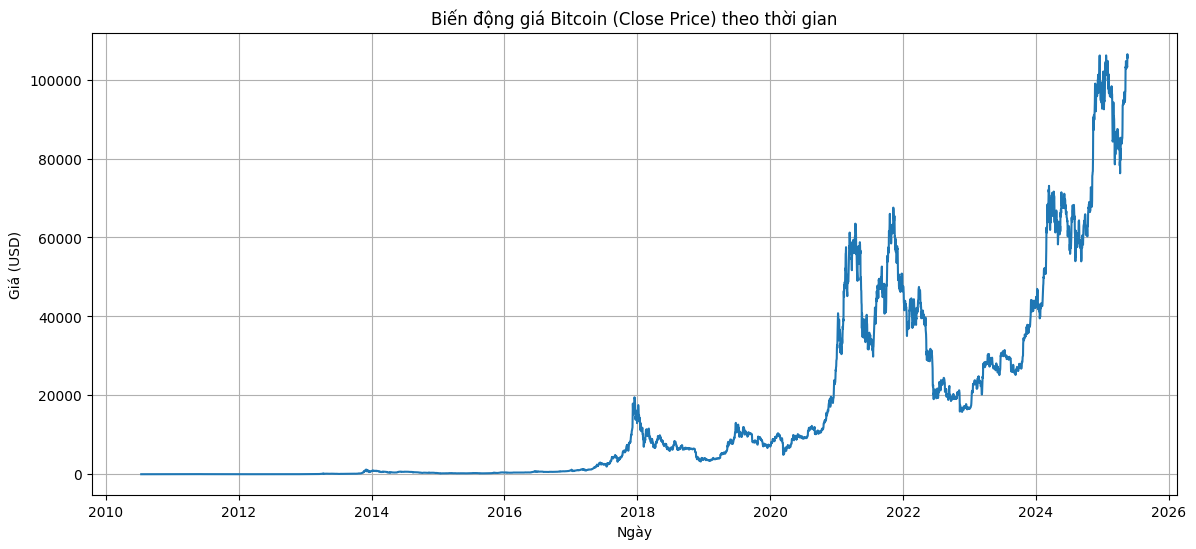

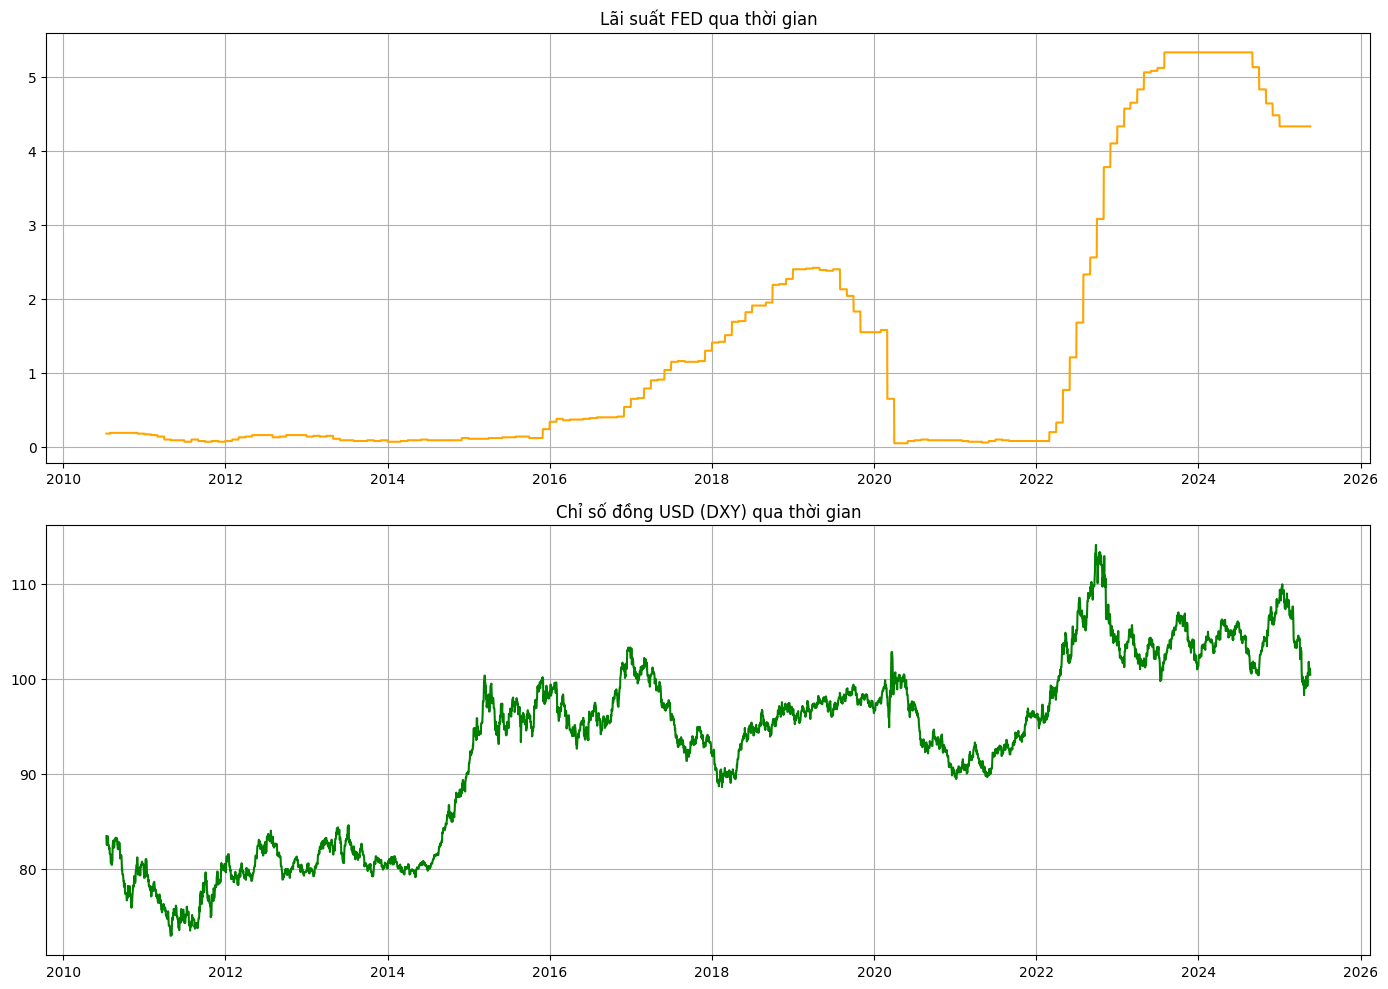

In [593]:
df_final = df_final.sort_values('timestamp')

# Vẽ giá Close theo thời gian
plt.figure(figsize=(14, 6))
plt.plot(df_final['timestamp'], df_final['close'])
plt.title("Biến động giá Bitcoin (Close Price) theo thời gian")
plt.xlabel("Ngày")
plt.ylabel("Giá (USD)")
plt.grid(True)
plt.show()

# Vẽ FEDFUNDS và US_Dollar_Price
fig, ax = plt.subplots(2, 1, figsize=(14, 10))
ax[0].plot(df_final['timestamp'], df_final['FEDFUNDS'], label="FEDFUNDS", color='orange')
ax[0].set_title("Lãi suất FED qua thời gian")
ax[0].grid(True)

ax[1].plot(df_final['timestamp'], df_final['US_Dollar_Price'], label="USD Index", color='green')
ax[1].set_title("Chỉ số đồng USD (DXY) qua thời gian")
ax[1].grid(True)

plt.tight_layout()
plt.show()


In [594]:
df_final['target_close'] = df_final['close'].shift(-1)

df_final = df_final.dropna()
df_final = df_final.reset_index(drop=True)

In [595]:
df_final['year'] = df_final['timestamp'].dt.year
df_final['month'] = df_final['timestamp'].dt.month
df_final['day'] = df_final['timestamp'].dt.day

# Cho biết biên bộ giá trong ngày -> nếu lớn thì có thể dự báo rủi ro hoặc cơ hội tăng mạnh hôm sau.
df_final['range_high_low'] = df_final['high'] - df_final['low']
# Cho biết giá thay đổi trong ngày -> dạng momentum -> cho biết có thể tiếp tục xu hướng giá.
df_final['change_open_close'] = df_final['close'] - df_final['open']
# Tỉ lệ % thay đổi giá so với giá hôm trước -> đặc trưng phổ biến trong tài chính để bắt tín hiệu xu hướng
df_final['close_pct_change'] = df_final['close'].pct_change().fillna(0)
# # Độ trễ 1 ngày của giá đóng cửa (giá close ngày hôm trước)
# df_final['close_lag_1'] = df_final['close'].shift(1)
# # Trung bình giá đóng cửa 3 ngày trước
# df_final['rolling_mean_3'] = df_final['close'].shift(1).rolling(window=3 ).mean()
# # Độ lệch chuẩn (volatility) của giá đóng cửa 3 ngày trước
# df_final['volatility_3'] = df_final['close'].shift(1).rolling(window=3).std()

df_final = df_final.dropna()
df_final = df_final.reset_index(drop=True)

df_final['high_minutes'] = df_final['timeHigh'].dt.hour * 60 + df_final['timeHigh'].dt.minute
df_final['low_minutes'] = df_final['timeLow'].dt.hour * 60 + df_final['timeLow'].dt.minute

# Drop cols after using
df_final = df_final.drop(['timeHigh', 'timeLow', 'timestamp'], axis=1)
df_final.head()

,open,high,low,close,volume,marketCap,FEDFUNDS,US_Dollar_Price,impact,target_close,year,month,day,range_high_low,change_open_close,close_pct_change,high_minutes,low_minutes
0,0.058157,0.061588,0.048647,0.056402,261.54,190259.65,0.18,83.43,1,0.057568,2010,7,14,0.012942,-0.001755,0.000000,34,1164
1,0.056403,0.067954,0.053969,0.057568,445.80,195982.14,0.18,82.56,1,0.066492,2010,7,15,0.013985,0.001165,0.020672,699,41
2,0.058001,0.072220,0.057484,0.066492,497.25,228047.42,0.18,82.49,1,0.065993,2010,7,16,0.014737,0.008490,0.155010,131,24
3,0.066500,0.077735,0.057418,0.065993,19.99,226904.80,0.18,82.49,1,0.078814,2010,7,17,0.020317,-0.000507,-0.007507,411,981
4,0.066088,0.080858,0.064221,0.078814,75.13,271669.20,0.18,82.49,1,0.074169,2010,7,18,0.016637,0.012726,0.194283,1058,28


In [596]:
encoder = OneHotEncoder(sparse_output=False, drop='first')
impact_encoded = encoder.fit_transform(df_final[['impact']])
impact_df = pd.DataFrame(impact_encoded, columns=encoder.get_feature_names_out(['impact']))
df_final = pd.concat([df_final, impact_df], axis=1)
df_final = df_final.drop('impact', axis=1)

In [597]:
df_final.head()

,open,high,low,close,volume,marketCap,FEDFUNDS,US_Dollar_Price,target_close,year,month,day,range_high_low,change_open_close,close_pct_change,high_minutes,low_minutes,impact_0,impact_1
0,0.058157,0.061588,0.048647,0.056402,261.54,190259.65,0.18,83.43,0.057568,2010,7,14,0.012942,-0.001755,0.000000,34,1164,0.0,1.0
1,0.056403,0.067954,0.053969,0.057568,445.80,195982.14,0.18,82.56,0.066492,2010,7,15,0.013985,0.001165,0.020672,699,41,0.0,1.0
2,0.058001,0.072220,0.057484,0.066492,497.25,228047.42,0.18,82.49,0.065993,2010,7,16,0.014737,0.008490,0.155010,131,24,0.0,1.0
3,0.066500,0.077735,0.057418,0.065993,19.99,226904.80,0.18,82.49,0.078814,2010,7,17,0.020317,-0.000507,-0.007507,411,981,0.0,1.0
4,0.066088,0.080858,0.064221,0.078814,75.13,271669.20,0.18,82.49,0.074169,2010,7,18,0.016637,0.012726,0.194283,1058,28,0.0,1.0


In [598]:
X = df_final.drop(columns=['target_close'])
y = df_final['target_close']

In [599]:
scalar_for_cols = ['open', 'high', 'low', 'close', 'volume', 'marketCap', 'FEDFUNDS', 'US_Dollar_Price',
                'range_high_low', 'change_open_close', 'close_pct_change',
                'high_minutes', 'low_minutes',
                ]

scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X[scalar_for_cols])

X_scaled = np.column_stack((X_scaled, X.drop(scalar_for_cols, axis=1)))

In [600]:
split_index = int(len(X_scaled) * 0.8)
X_train, X_test = X_scaled[:split_index], X_scaled[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# tscv = TimeSeriesSplit(n_splits=5)

# for train_index, test_index in tscv.split(X_scaled):
#     X_train, X_test = X_scaled[train_index], X_scaled[test_index]
#     y_train, y_test = y[train_index], y[test_index]

# X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, shuffle=False)

In [601]:
print(X_train[0:2])
print(y_train[0:2])

[[-6.69372755e-01 -6.70073386e-01 -6.68467192e-01 -6.69309730e-01
  -7.07990179e-01 -6.53204633e-01 -6.57354708e-01 -1.00322232e+00
  -5.55671506e-01 -2.07242226e-02 -7.96535970e-02 -1.25681763e+00
   1.16622432e+00  2.01000000e+03  7.00000000e+00  1.40000000e+01
   0.00000000e+00  1.00000000e+00]
 [-6.69372829e-01 -6.70073125e-01 -6.68466964e-01 -6.69309681e-01
  -7.07990170e-01 -6.53204620e-01 -6.57354708e-01 -1.09558961e+00
  -5.55670701e-01 -2.07208782e-02  3.51020078e-01  7.39841460e-02
  -1.13759199e+00  2.01000000e+03  7.00000000e+00  1.50000000e+01
   0.00000000e+00  1.00000000e+00]]
0    0.057568
1    0.066492
Name: target_close, dtype: float64


Accuracy: 99.69%
Linear Regression - MSE: 2267266.5365299867, R2: 0.9969190586874687, MAE: 937.7231732175114, MAPE: 1.9147294988409187%


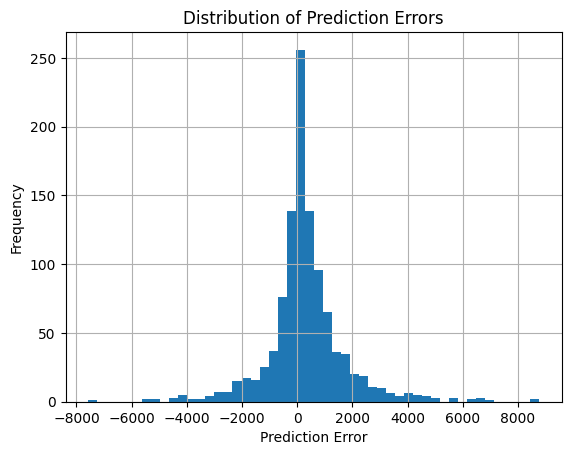

Accuracy: 76.99%
Random Forest - MSE: 169356946.5537952, R2: 0.7698643698061498, MAE: 6508.819337147357, MAPE: 8.788848007512046%


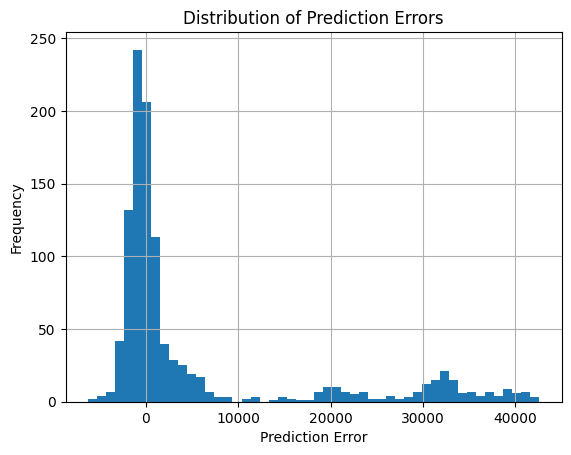

Accuracy: 76.33%
Gradient Boosting - MSE: 174200869.05599532, R2: 0.7632820643245148, MAE: 6648.351484418171, MAPE: 9.17842883460224%


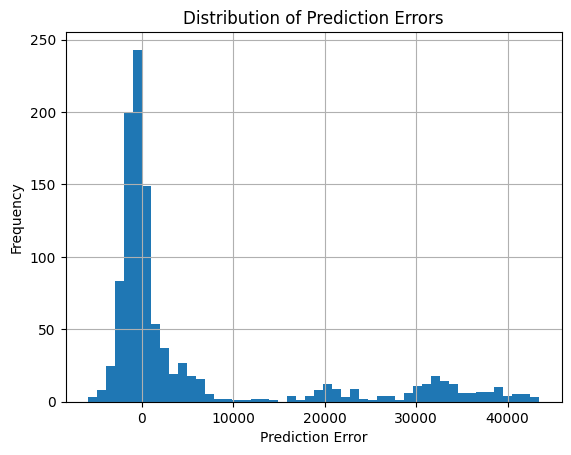

In [602]:
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42)
}

results = {}

for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print(f"Accuracy: {model.score(X_test, y_test) * 100:.2f}%")

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mape = (abs(y_test - y_pred) / y_test).mean() * 100

    results[model_name] = {
        'MSE': mse,
        'R2': r2,
        'MAE': mae,
        'MAPE': mape
    }

    print(f"{model_name} - MSE: {mse}, R2: {r2}, MAE: {mae}, MAPE: {mape}%")

    # Phân phối sai số dự đoán (actual - predicted)
    errors = y_test - y_pred
    plt.hist(errors, bins=50)
    plt.title("Distribution of Prediction Errors")
    plt.xlabel("Prediction Error")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

In [609]:
def preprocess_data(data_dict, scaler_X, encoder, scalar_for_cols):
    data = pd.DataFrame([data_dict])

    data['timestamp'] = pd.to_datetime(data['timestamp'])
    data['year'] = data['timestamp'].dt.year
    data['month'] = data['timestamp'].dt.month
    data['day'] = data['timestamp'].dt.day

    data['range_high_low'] = data['high'] - data['low']
    data['change_open_close'] = data['close'] - data['open']
    data['close_pct_change'] = data['close'].pct_change().fillna(0)

    data['timeHigh'] = pd.to_datetime(data['timeHigh'])
    data['timeLow'] = pd.to_datetime(data['timeLow'])
    data['high_minutes'] = data['timeHigh'].dt.hour * 60 + data['timeHigh'].dt.minute
    data['low_minutes'] = data['timeLow'].dt.hour * 60 + data['timeLow'].dt.minute

    data = data.drop(['timeHigh', 'timeLow', 'timestamp'], axis=1)

    encoded_cols = encoder.transform(data[['impact']])
    encoded_df = pd.DataFrame(encoded_cols, columns=encoder.get_feature_names_out(['impact']))
    data = pd.concat([data, encoded_df], axis=1)
    data = data.drop('impact', axis=1)

    scaler_data = scaler_X.transform(data[scalar_for_cols])
    scaler_data = np.column_stack((scaler_data, data.drop(scalar_for_cols, axis=1)))

    return scaler_data

def predict_in_day(model, X):
    predicted = model.predict(X)

    return {
        'predicted_close': predicted[0],
    }

In [ ]:
def process_pred(
    model,
    initial_data_dict,
    scaler_X,
    encoder,
    scalar_for_cols,
    n_days=5
):
    forecast_dates = []
    forecast_prices = []

    data_dict = initial_data_dict.copy()

    for i in range(n_days):
        # Tiền xử lý
        X_input = preprocess_data(data_dict, scaler_X, encoder, scalar_for_cols)
        
        # Dự đoán
        result = predict_in_day(model, X_input)
        predicted_close = result['predicted_close']
        
        # Lưu lại ngày và giá
        forecast_date = pd.to_datetime(data_dict['timestamp']) + timedelta(days=1)
        forecast_dates.append(forecast_date)
        forecast_prices.append(predicted_close)

        # Cập nhật dữ liệu cho ngày kế tiếp
        data_dict['timestamp'] = forecast_date.strftime("%Y-%m-%d %H:%M:%S")
        data_dict['close'] = predicted_close  # dùng giá dự đoán làm close cho ngày tiếp theo

        # Cập nhật dữ liệu khác nếu cần

    # Vẽ biểu đồ
    plt.figure(figsize=(10, 5))
    plt.plot(forecast_dates, forecast_prices, marker='o', linestyle='--', color='blue', label='Dự đoán')
    plt.title(f'Dự đoán giá trong {n_days} ngày tiếp theo')
    plt.xlabel('Ngày')
    plt.ylabel('Giá đóng cửa dự đoán')
    plt.grid(True)
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    return forecast_dates, forecast_prices

[[ 3.79309925e+00  3.72697058e+00  3.70804281e+00  3.75316817e+00
   2.42536775e+00  3.82804478e+00  1.67979350e+00  8.01655932e-01
   3.27069448e+00 -9.64701057e-01 -7.96535970e-02 -1.30684777e+00
  -4.01109303e-01  2.02500000e+03  5.00000000e+00  1.90000000e+01
   0.00000000e+00  1.00000000e+00]]
[[ 3.79309925e+00  3.72697058e+00  3.70804281e+00  3.74691402e+00
   2.42536775e+00  3.82804478e+00  1.67979350e+00  8.01655932e-01
   3.27069448e+00 -1.13571901e+00 -7.96535970e-02 -1.30684777e+00
  -4.01109303e-01  2.02500000e+03  5.00000000e+00  2.00000000e+01
   0.00000000e+00  1.00000000e+00]]
[[ 3.79309925e+00  3.72697058e+00  3.70804281e+00  3.74017411e+00
   2.42536775e+00  3.82804478e+00  1.67979350e+00  8.01655932e-01
   3.27069448e+00 -1.32001991e+00 -7.96535970e-02 -1.30684777e+00
  -4.01109303e-01  2.02500000e+03  5.00000000e+00  2.10000000e+01
   0.00000000e+00  1.00000000e+00]]
[[ 3.79309925e+00  3.72697058e+00  3.70804281e+00  3.73290913e+00
   2.42536775e+00  3.82804478e+00 

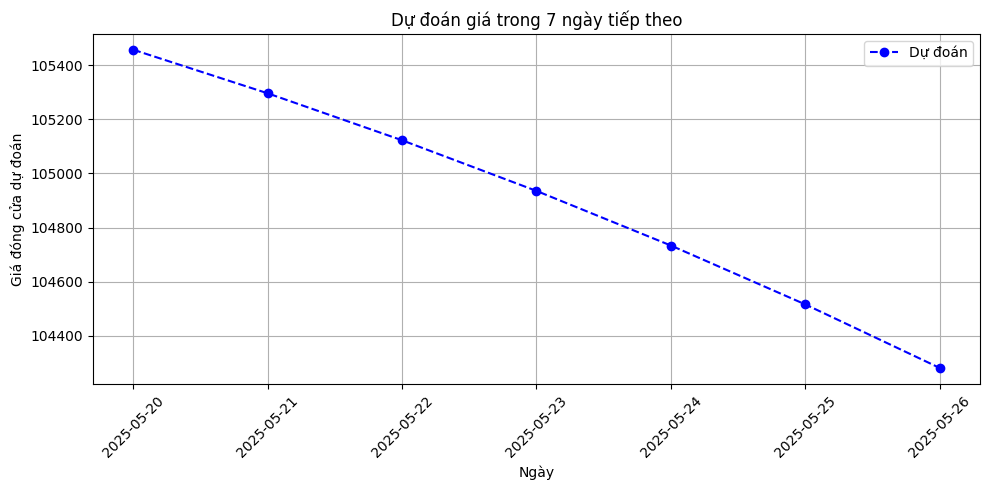

([Timestamp('2025-05-20 00:00:00'),
  Timestamp('2025-05-21 00:00:00'),
  Timestamp('2025-05-22 00:00:00'),
  Timestamp('2025-05-23 00:00:00'),
  Timestamp('2025-05-24 00:00:00'),
  Timestamp('2025-05-25 00:00:00'),
  Timestamp('2025-05-26 00:00:00')],
 [np.float64(105456.83610651604),
  np.float64(105295.89110762696),
  np.float64(105122.40758813368),
  np.float64(104935.37067147577),
  np.float64(104733.68333627956),
  np.float64(104516.15976749998),
  np.float64(104281.51816939915)])

In [611]:
best_model = models['Linear Regression']  # hoặc Random Forest, Linear Regression
initial_data_dict = {
    'open': 106430.532703,
    'high': 107068.722368,
    'low': 102112.685460,
    'close': 105606.1814675408,
    'volume': 6.176113e+10,
    'marketCap': 2.098071e+12,
    'FEDFUNDS': 4.33,
    'US_Dollar_Price': 100.43,
    'impact': 1,
    'timeHigh': '2025-05-19T00:09:00.000Z',
    'timeLow': '2025-05-19T06:40:00.000Z',
    'timestamp': '2025-05-19'
}
process_pred(best_model, initial_data_dict, scaler_X, encoder, scalar_for_cols, n_days=7)
